In [1]:
import pandas as pd
import dataframe_image as dfi
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()
attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
savefig = False

In [3]:
# final dataset for stats
data = np.load(filepath + 'results/data_experiment.npy',allow_pickle='TRUE')
Nsj = len(data)
print('number of subjects: ' + str(Nsj))

number of subjects: 108


In [4]:
mood_rating_list, symptoms_list = [], []
df = pd.DataFrame()
for j, i in enumerate(data):
    mood_rating_list.append(i['ratings'])
    df.loc[j, 'randomized_condition'] = int(i['iddoc']['intervention_condition'] == 0) # 0=control, 1=distancing
    df.loc[j, 'randomized_videoset'] = i['iddoc']['videoset_condition']
    df.loc[j, 'intervention_success'] = \
    prep.extract_intervention_success(i['datadoc']['intervention_sucess_response'])
    symptoms_list.append(i['symptoms'])
mood_ratings = np.array(mood_rating_list).T
symptoms = np.array(symptoms_list)

mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), \
                               np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
T = np.shape(mood_ratings[:,:,0])[0]
for t in range(2):
    mood_ratings_split[:,:,:,t] = mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:]

In [5]:
# check randomization
for i in range(2):
    for j in range(2):
        print('videoset = ' + str(i) + ', condition = ' + str(j), end=': ')
        print(round(np.sum((df['randomized_videoset']==i)&(df['randomized_condition']==j))/len(data),2))

videoset = 0, condition = 0: 0.29
videoset = 0, condition = 1: 0.27
videoset = 1, condition = 0: 0.19
videoset = 1, condition = 1: 0.26


In [6]:
mm = df['randomized_condition']
print('allocated to distancing: ' + str(mm.sum()) + '(' + str(mm.mean().round(2)) + '%)')

allocated to distancing: 57.0(0.53%)


mean: [True, True, False, False, False]
variance: [False, False, False, False, False]


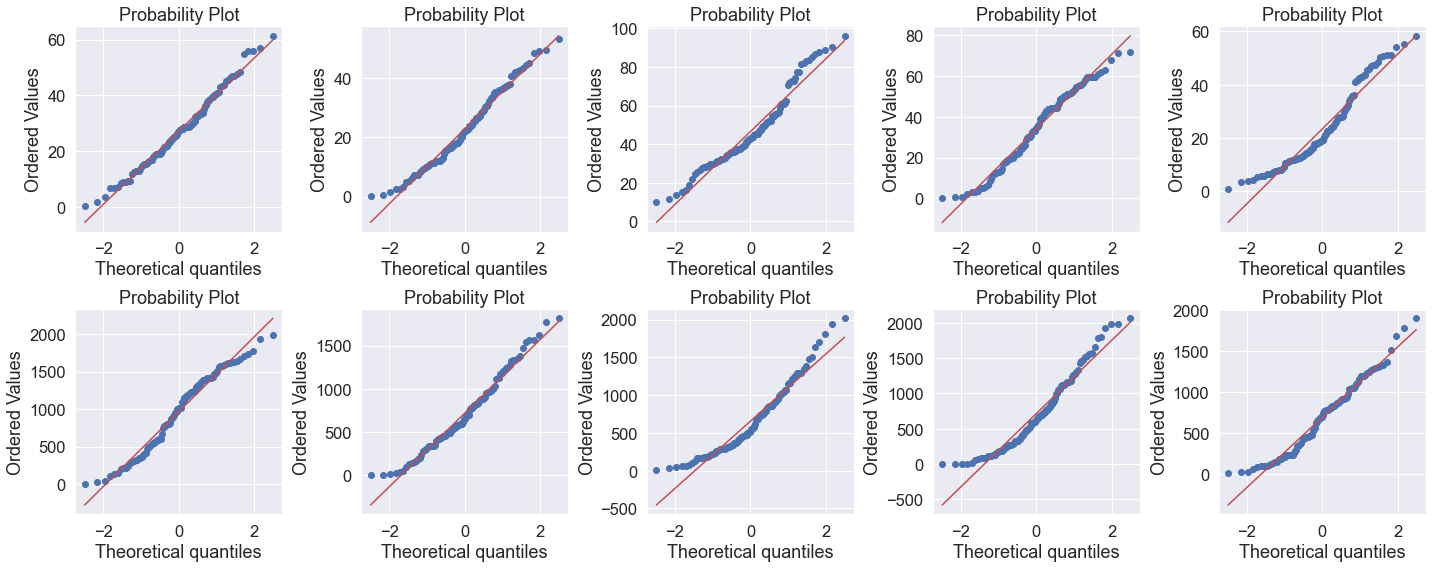

In [7]:
# test normality of mean and variance of ratings
print('mean: ' + str(emostats.test_normality(np.nanmean(mood_ratings_split[1:,:,:,0],axis=0))))
print('variance: ' + str(emostats.test_normality(np.nanvar(mood_ratings_split[1:,:,:,0],axis=0))))
fig,axs = plt.subplots(2,5,figsize=(20,8))
for j in range(5):
    scipy.stats.probplot(np.nanmean(mood_ratings_split[1:,j,:,0],axis=0), plot=axs[0,j])
    scipy.stats.probplot(np.nanvar(mood_ratings_split[1:,j,:,0],axis=0), plot=axs[1,j])
plt.tight_layout()

In [8]:
# table average ratings split in intervention group and before and after
condition_label = ['emotion regulation intervention', 'control intervention']
mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), \
                               np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
for i in range(2):
    print(condition_label[i] +' group:')
    mm = []
    T = np.shape(mood_ratings[:,:,0])[0]
    for t in range(2):
        mood_ratings_split[:,:,:,t] = mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:]
        mm.append(np.nanmean(mood_ratings_split[:,:,(df['randomized_condition']==i), t],axis=(0,2)))
        mm.append(np.nanmean(np.nanstd(mood_ratings_split[:,:,(df['randomized_condition']==i), t],axis=0),axis=1))
    display(pd.DataFrame(mm, columns=mood_categories, \
                             index=['mean before', 'std before', 'mean after', 'std after']).T.round(2))

emotion regulation intervention group:


,mean before,std before,mean after,std after
disgusted,27.07,31.47,29.21,30.15
amused,24.79,27.17,22.00,24.83
calm,46.83,24.47,46.50,21.47
anxious,33.55,26.20,36.14,24.20
sad,22.40,26.29,25.33,26.42


control intervention group:


,mean before,std before,mean after,std after
disgusted,26.63,27.85,15.90,18.64
amused,21.01,23.49,15.41,16.09
calm,47.23,23.89,57.95,15.77
anxious,33.81,22.92,20.61,15.10
sad,23.99,23.09,14.97,15.13


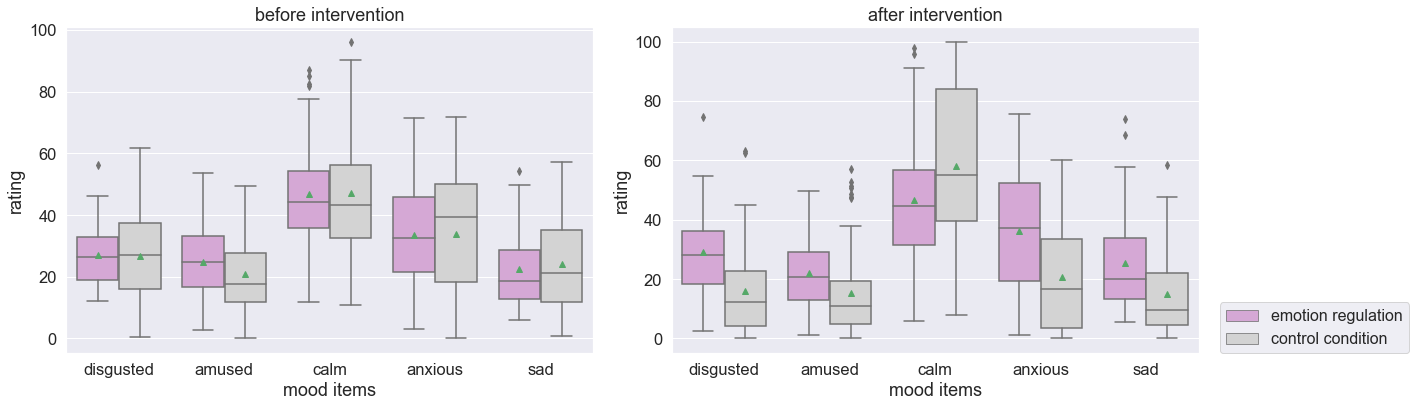

In [9]:
# plot showing mean before and after intervention split for condition
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
my_pal = {"left": "blue", "right": "red"}
time_label = ['before intervention', 'after intervention']
fig, axs = plt.subplots(1,2, figsize=[20,6])
for t in range(2):
    tmp = pd.DataFrame(np.nanmean(mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:],axis=0).T, \
                       columns=mood_categories)
    tmp['condition'] = df['randomized_condition']
    tmp = tmp.melt(id_vars=['condition'], value_vars=mood_categories, value_name='rating', var_name='category')
    b = sns.boxplot(data=tmp, x='category', y='rating', hue='condition', \
                    showmeans=True, ax = axs[t], palette={0: "plum", 1: "lightgrey"}) \
                    #meanprops={"markerfacecolor":"grey", "markeredgecolor":"grey"})
    b.set(title=time_label[t], ylabel='rating', xlabel='mood items')
    if t == 1: 
        b.legend(loc=(1.04, 0), fontsize=16)
        b.legend_.texts[0].set_text('emotion regulation')
        b.legend_.texts[1].set_text('control condition')
    else: 
            b.legend([],[], frameon=False)
fig.tight_layout()

,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,6.53,1.26,0.288,10.05,1.93,0.095
after intervention,24.48,4.71,< 0.001,36.53,7.03,< 0.001
change (after - before),52.66,10.14,< 0.001,19.90,3.83,0.003


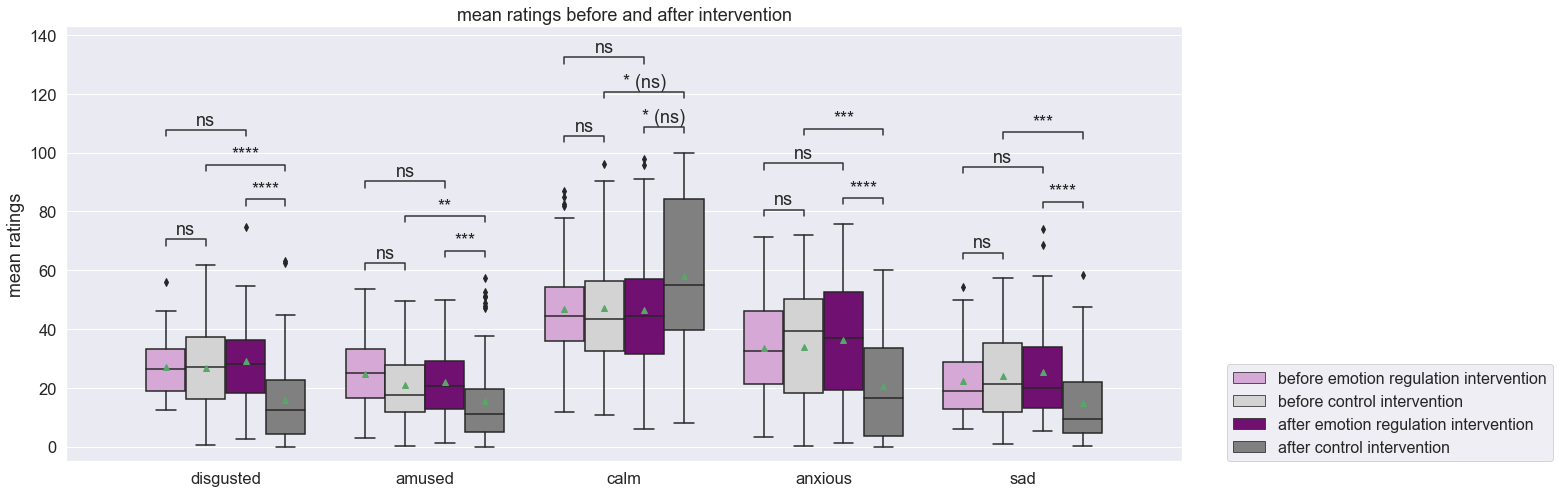

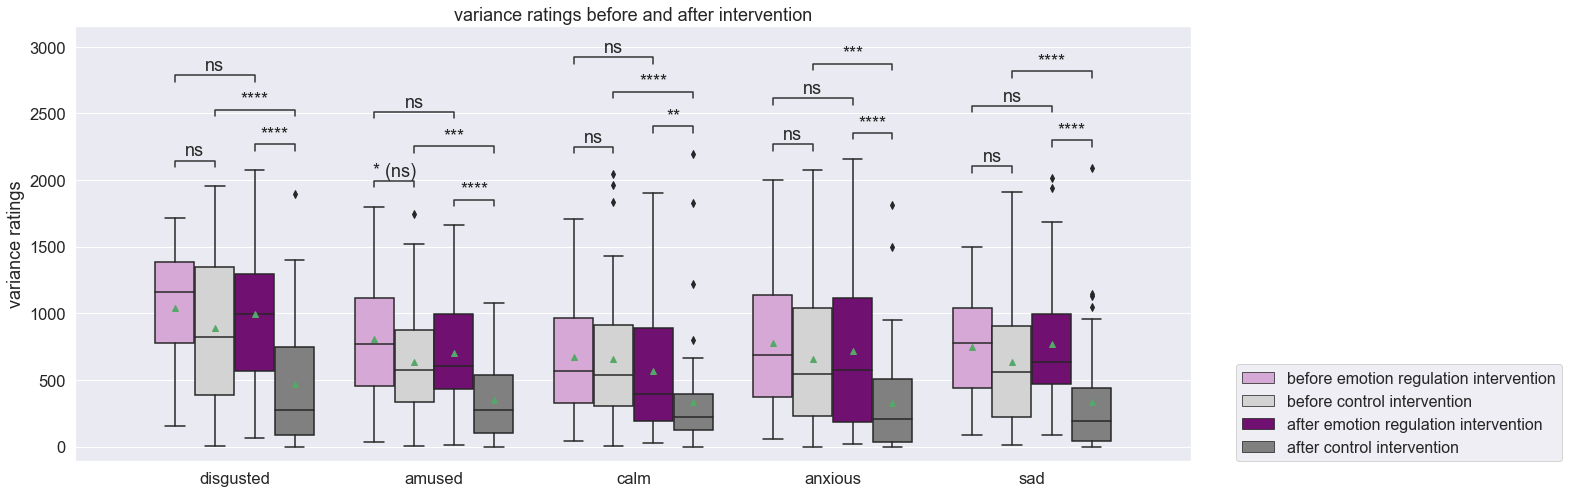

In [10]:
#  all in one plots showing ratings averaged over participants and HotellingTtest table
label= ['mean', 'variance']
pairs = []
for t in range(2):
    for i in mood_categories:
        pairs.append([(i, 0+t), (i, 2+t)])
        pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])
        
df_stats_both = pd.DataFrame()
for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]):
    df_stats, pvalues, tvalues = emostats.stats_group_difference(i, df)
    df_plot = emostats.make_df(i, df, mood_categories)
    fig, ax = plt.subplots(figsize=(20,8))
    fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                             data_name=label[j] + ' ratings' , pairs=pairs, fig=fig, ax=ax)
    ax.set(ylabel=label[j] + ' ratings')
    df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)

display(df_stats_both)
# print(df_stats_both.to_latex())

In [11]:
# statistics table including group comparisons and before and after comparisons 
print('multiple comparison: ' + str(0.05/15))
df_stats = pd.DataFrame()
for j in [np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]:
    pval, statistics = [np.empty((4,5)) for i in range(2)]
    mm1, mm2 = [np.empty((4,5), dtype=object) for i in range(2)]
    
    for t in range(2):
        for i in range(5):
            dd = j[i,:,t]
            statistics[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                       dd[df['randomized_condition']==1]).statistic
            pval[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                 dd[df['randomized_condition']==1]).pvalue
            mm1[t,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==0])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==0]))))
            mm2[t,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==1])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==1]))))
    for g in range(2):
        for i in range(5):
            dd = j[i,:,:]
            statistics[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                                   dd[df['randomized_condition']==g,1]).statistic
            pval[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                             dd[df['randomized_condition']==g,1]).pvalue
            mm1[g+2,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==g,0])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==g,0]))))
            mm2[g+2,i] = str(int(np.round(np.nanmean(dd[df['randomized_condition']==g,1])))) + '$\pm$' + \
                       str(int(np.round(np.nanstd(dd[df['randomized_condition']==g,1]))))
    statsarray = np.empty((4,20),dtype=object)
    for i in range(4):
        for j in range(5):
            statsarray[i,j*4] = mm1[i,j]
            statsarray[i,j*4+1] = mm2[i,j]
            statsarray[i,j*4+2] = np.round(statistics[i,j],2)
            if pval[i,j] < 0.001:statsarray[i,j*4+3] = '$<$0.001'
            else: statsarray[i,j*4+3] = np.round(pval[i,j],3)
    header = [np.repeat(mood_categories,4), len(mood_categories) * ['v1 (M$\pm$SD)', 'v2 (M$\pm$SD)', 'statistics', 'pvalue']]
    df_stats = pd.concat((df_stats, pd.DataFrame(statsarray, index=['group comparison at t=0', 'group comparison t=1', \
                            'before vs after g=0', 'before vs after g=1'], columns=header)))
df_stats.index =  [np.repeat(['mean', 'variance'], 4), df_stats.index]
df_stats.round(2)
# print(df_stats.round(2).to_latex(escape=False))

multiple comparison: 0.0033333333333333335


disgusted                           \
                                 v1 (M$\pm$SD) v2 (M$\pm$SD) statistics   
mean     group comparison at t=0     27$\pm$10     27$\pm$15     1514.5   
         group comparison t=1        29$\pm$14     16$\pm$15     2219.0   
         before vs after g=0         27$\pm$10     29$\pm$14      525.5   
         before vs after g=1         27$\pm$15     16$\pm$15      152.0   
variance group comparison at t=0  1041$\pm$409   888$\pm$549     1705.0   
         group comparison t=1      992$\pm$517   472$\pm$451     2255.0   
         before vs after g=0      1041$\pm$409   992$\pm$517      616.0   
         before vs after g=1       888$\pm$549   472$\pm$451      147.0   

                                                  amused                \
                                    pvalue v1 (M$\pm$SD) v2 (M$\pm$SD)   
mean     group comparison at t=0      0.71     25$\pm$11     21$\pm$13   
         group comparison t=1     $<$0.001     22$\pm$13     15$\pm$16   
         before vs after g=0         0.197     25$\pm$11     22$\pm$13   
         before vs after g=1      $<$0.001     21$\pm$13     15$\pm$16   
variance group comparison at t=0     0.122   804$\pm$422   633$\pm$399   
         group comparison t=1     $<$0.001   703$\pm$434   349$\pm$317   
         before vs after g=0          0.66   804$\pm$422   703$\pm$434   
         before vs after g=1      $<$0.001   633$\pm$399   349$\pm$317   

                                                               calm  \
                                 statistics    pvalue v1 (M$\pm$SD)   
mean     group comparison at t=0     1738.5      0.08     47$\pm$18   
         group comparison t=1        1997.0  $<$0.001     46$\pm$22   
         before vs after g=0          273.0  $<$0.001     47$\pm$18   
         before vs after g=1          308.0  $<$0.001     47$\pm$20   
variance group comparison at t=0     1787.0      0.04   673$\pm$435   
         group comparison t=1        2164.0  $<$0.001   564$\pm$478   
         before vs after g=0          345.0     0.003   673$\pm$435   
         before vs after g=1          246.0  $<$0.001   660$\pm$475   

                                                                     \
                                 v2 (M$\pm$SD) statistics    pvalue   
mean     group comparison at t=0     47$\pm$20     1497.0     0.791   
         group comparison t=1        58$\pm$26     1083.5     0.023   
         before vs after g=0         46$\pm$22      560.5     0.337   
         before vs after g=1         58$\pm$26      279.0  $<$0.001   
variance group comparison at t=0   660$\pm$475     1502.0     0.768   
         group comparison t=1      331$\pm$395     1924.0     0.004   
         before vs after g=0       564$\pm$478      323.0     0.001   
         before vs after g=1       331$\pm$395      133.0  $<$0.001   

                                       anxious                           \
                                 v1 (M$\pm$SD) v2 (M$\pm$SD) statistics   
mean     group comparison at t=0     34$\pm$16     34$\pm$20     1422.0   
         group comparison t=1        36$\pm$20     21$\pm$18     2091.0   
         before vs after g=0         34$\pm$16     36$\pm$20      471.0   
         before vs after g=1         34$\pm$20     21$\pm$18       68.0   
variance group comparison at t=0   778$\pm$511   654$\pm$529     1682.0   
         group comparison t=1      715$\pm$569   330$\pm$377     2098.0   
         before vs after g=0       778$\pm$511   715$\pm$569      566.0   
         before vs after g=1       654$\pm$529   330$\pm$377      187.0   

                                                     sad                \
                                    pvalue v1 (M$\pm$SD) v2 (M$\pm$SD)   
mean     group comparison at t=0     0.849     22$\pm$12     24$\pm$16   
         group comparison t=1     $<$0.001     25$\pm$16     15$\pm$14   
         before vs after g=0         0.072     22$\pm$12     25$\pm$16   
  

In [12]:
# MANOVA including group and before and after interaction
from statsmodels.multivariate.manova import MANOVA
for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), \
                       np.nanvar(mood_ratings_split,axis=0)]):
    print(['mean', 'variance'][j])
    df_manova = pd.DataFrame()
    for t in range(2):
        df_manova = pd.concat((df_manova, pd.DataFrame(i[:,:,t])),axis=1, \
                            ignore_index=True)
    df_manova = df_manova.T
    # df_test.columns = [i + str(t) for t in range(2) for i in mood_categories]
    df_manova.columns = mood_categories
    df_manova['time'] = np.concatenate((np.zeros([108,1]),np.ones([108,1])))
    df_manova['condition'] = np.concatenate((df['randomized_condition'].values,df['randomized_condition'].values))
    fit = MANOVA.from_formula('disgusted + amused + calm + anxious + sad ~ condition*time', data=df_manova)
    display(fit.mv_test().summary_frame)

mean


Value Num DF Den DF     F Value  \
Effect         Statistic                                                    
Intercept      Wilks' lambda           0.188486      5  208.0  179.105491   
               Pillai's trace          0.811514    5.0  208.0  179.105491   
               Hotelling-Lawley trace   4.30542      5  208.0  179.105491   
               Roy's greatest root      4.30542      5    208  179.105491   
condition      Wilks' lambda           0.975054      5  208.0    1.064301   
               Pillai's trace          0.024946    5.0  208.0    1.064301   
               Hotelling-Lawley trace  0.025584      5  208.0    1.064301   
               Roy's greatest root     0.025584      5    208    1.064301   
time           Wilks' lambda           0.977691      5  208.0    0.949219   
               Pillai's trace          0.022309    5.0  208.0    0.949219   
               Hotelling-Lawley trace  0.022818      5  208.0    0.949219   
               Roy's greatest root     0.022818      5    208    0.949219   
condition:time Wilks' lambda           0.941113      5  208.0    2.602998   
               Pillai's trace          0.058887    5.0  208.0    2.602998   
               Hotelling-Lawley trace  0.062572      5  208.0    2.602998   
               Roy's greatest root     0.062572      5    208    2.602998   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.381261  
               Pillai's trace          0.381261  
               Hotelling-Lawley trace  0.381261  
               Roy's greatest root     0.381261  
time           Wilks' lambda           0.450169  
               Pillai's trace          0.450169  
               Hotelling-Lawley trace  0.450169  
               Roy's greatest root     0.450169  
condition:time Wilks' lambda           0.026208  
               Pillai's trace          0.026208  
               Hotelling-Lawley trace  0.026208  
               Roy's greatest root     0.026208

variance


Value Num DF Den DF    F Value  \
Effect         Statistic                                                   
Intercept      Wilks' lambda           0.415844      5  208.0  58.437553   
               Pillai's trace          0.584156    5.0  208.0  58.437553   
               Hotelling-Lawley trace  1.404749      5  208.0  58.437553   
               Roy's greatest root     1.404749      5    208  58.437553   
condition      Wilks' lambda           0.960274      5  208.0   1.720959   
               Pillai's trace          0.039726    5.0  208.0   1.720959   
               Hotelling-Lawley trace  0.041369      5  208.0   1.720959   
               Roy's greatest root     0.041369      5    208   1.720959   
time           Wilks' lambda           0.970623      5  208.0    1.25907   
               Pillai's trace          0.029377    5.0  208.0    1.25907   
               Hotelling-Lawley trace  0.030266      5  208.0    1.25907   
               Roy's greatest root     0.030266      5    208    1.25907   
condition:time Wilks' lambda           0.960255      5  208.0   1.721829   
               Pillai's trace          0.039745    5.0  208.0   1.721829   
               Hotelling-Lawley trace   0.04139      5  208.0   1.721829   
               Roy's greatest root      0.04139      5    208   1.721829   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.131124  
               Pillai's trace          0.131124  
               Hotelling-Lawley trace  0.131124  
               Roy's greatest root     0.131124  
time           Wilks' lambda           0.282971  
               Pillai's trace          0.282971  
               Hotelling-Lawley trace  0.282971  
               Roy's greatest root     0.282971  
condition:time Wilks' lambda           0.130926  
               Pillai's trace          0.130926  
               Hotelling-Lawley trace  0.130926  
               Roy's greatest root     0.130926

----
Symptoms
--

In [19]:
# data of 3 psychological questionnaires were collected
questionnaires = {'phq': range(0,10), 'gad': range(10,10+7), 'ders': range(17,17+18)}
for i in questionnaires.items():
    df[i[0]] = np.nanmean(symptoms[:,i[1]],axis=1)
    df[i[0]] = prep.zscore(df[i[0]])
symptoms_normalized = prep.zscore(symptoms)
df.to_csv('../results/questionnaire_data.csv')

mean: [False, False, False]


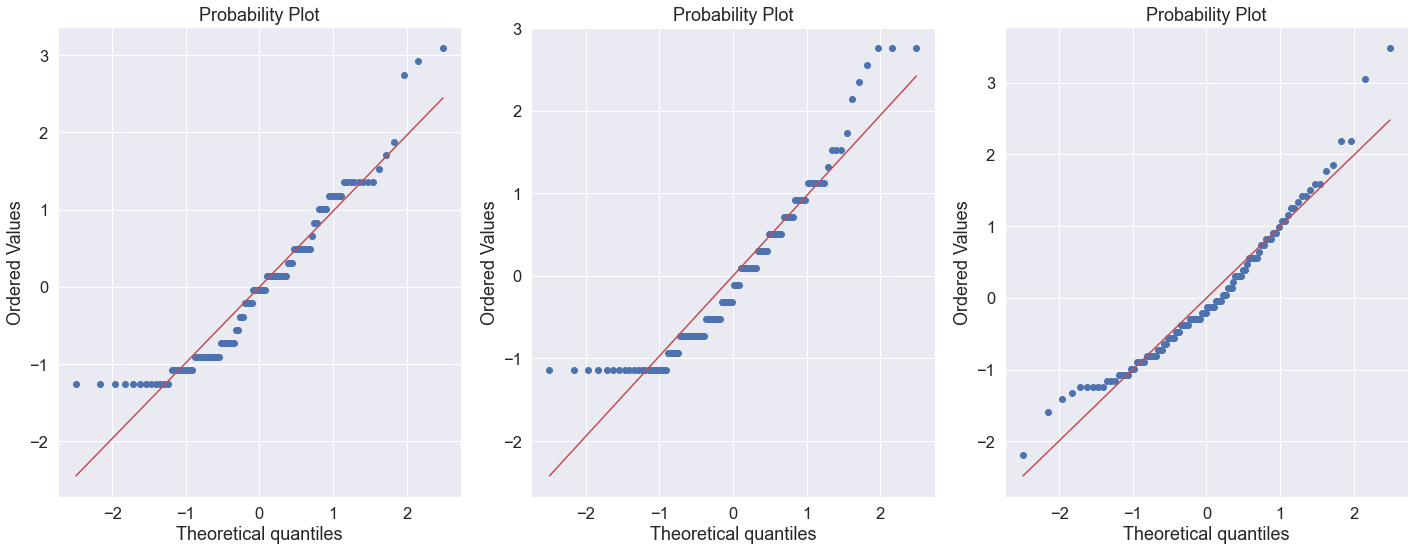

In [14]:
# test normality of mean and variance of ratings
print('mean: ' + str(emostats.test_normality(df[questionnaires.keys()].to_numpy().T)))
fig,axs = plt.subplots(1,3,figsize=(20,8))
for j in range(3):
    scipy.stats.probplot(df[questionnaires.keys()].to_numpy()[:,j], plot=axs[j])
plt.tight_layout()

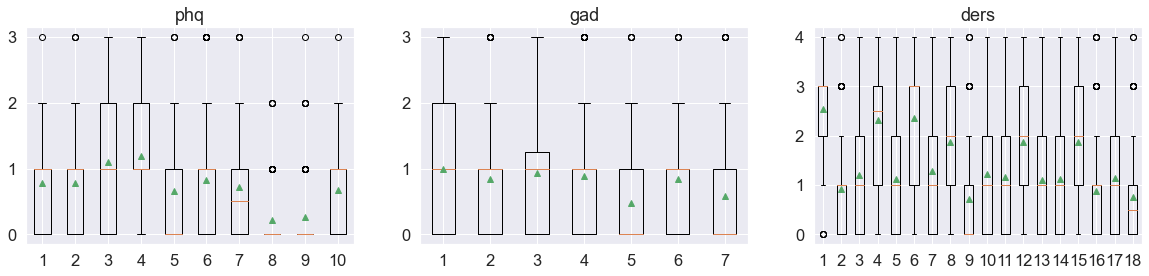

In [15]:
fi,ax = plt.subplots(1,3,figsize=(20,4))
for j,i in enumerate(questionnaires.items()):
    ax[j].boxplot(symptoms[:,i[1]], showmeans=True);
    ax[j].set_title(i[0])

In [16]:
# correlation between questionnaires
display(df[questionnaires.keys()].corr())

,phq,gad,ders
phq,1.000000,0.753185,0.690018
gad,0.753185,1.000000,0.732192
ders,0.690018,0.732192,1.000000


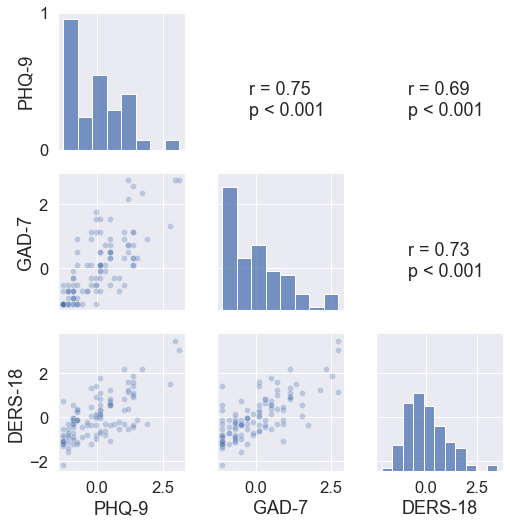

In [18]:
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = scipy.stats.pearsonr(x,y)
    if p < 0.001: p = '< 0.001'
    else: p = '= ' + str(np.round(p,2))
    ax.annotate('r = ' + str(np.round(r,2)) + '\np ' + p, xy=(0.25,0.25), xycoords='axes fraction', ha='left')
    ax.set_axis_off()

g = sns.PairGrid(df[questionnaires.keys()], hue=None)
g.map_upper(reg_coef, hue=None)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot, alpha=0.3)
k,j = 0,0
for i, ax in enumerate(g.axes.flat):
    if i == 0: 
        ax.set_yticks([0,1])
        ax.set_yticklabels([0,1])
    if i in [0,3,6]: 
        ax.set_ylabel(questionnaire_label[k])
        k += 1
    if i > 5: 
        ax.set_xlabel(questionnaire_label[j])
        j += 1
if savefig:
    plt.savefig(filepath + 'results/figures/questionnaires.png')

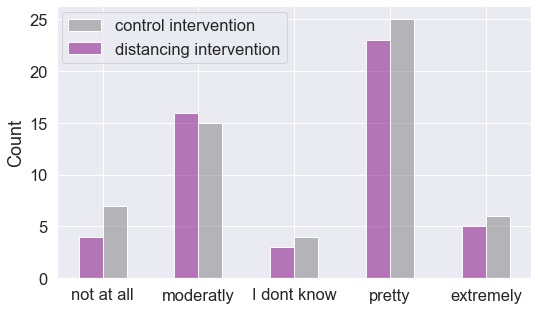

In [19]:
# histogram showing how successfull they thought they were using the intervention
fig,axs = plt.subplots(figsize=(8.5,5))
b = sns.histplot(data=df, x='intervention_success', hue='randomized_condition', multiple="dodge", \
                 shrink=0.5, ax=axs ,discrete=True, palette={0: "purple", 1: "grey"}, legend=False, alpha=0.5)
b.set_xlabel('');
b.set_xticks(range(5));
b.set_xticklabels(['not at all', 'moderatly', 'I dont know', 'pretty', 'extremely']);
b.legend(['control intervention','distancing intervention'],loc=(0.01, 0.79))
if savefig:
    plt.savefig(filepath + 'results/figures/intervention_success.svg')

In [20]:
# relation between DERS and intervention success
print(scipy.stats.spearmanr(df['ders'], df['intervention_success']))
display(smf.glm('intervention_success ~ ders', df, missing='drop').fit().summary().tables[1])
model = smf.glm('intervention_success ~ ders * randomized_condition', df, missing='drop').fit()
df_new = pd.DataFrame(model.summary().tables[1][1:], columns=model.summary().tables[1][0])
df_new = df_new.iloc[: , 1:]
df_new.index = ['Intercept', 'DERS-18', 'intervention', 'intervention * DERS-18']
display(df_new)
# dfi.export(df_new, filepath + 'results/figures/interventionsuccessVSDERS.png')

SpearmanrResult(correlation=-0.2318134156516171, pvalue=0.015777453888499843)


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.1574,0.116,18.586,0.000,1.930,2.385
ders,-0.3053,0.116,-2.630,0.009,-0.533,-0.078


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.1833,0.170,12.811,0.000,1.849,2.517
DERS-18,-0.2621,0.163,-1.612,0.107,-0.581,0.057
intervention,-0.0511,0.235,-0.218,0.828,-0.511,0.409
intervention * DERS-18,-0.0911,0.234,-0.389,0.697,-0.551,0.368


the higher they score in DERS the lower they judged their intervention success,
however does not seem specific to emotion regulation intervention

----
Relation with symptoms
--

In [26]:
# relation betweeen mean and variance of emotion ratings (baseline, before and after intervention) 
# and the three questionnaires
df_mood = df.copy()
timing = {'baseline': mood_ratings[0,:,:].T, \
          'mean_t1': np.nanmean(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
          'mean_t2': np.nanmean(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T, \
          'var_t1': np.nanvar(mood_ratings[1:int(np.shape(mood_ratings)[0]/2),:,:],axis=0).T, \
          'var_t2': np.nanvar(mood_ratings[int(np.shape(mood_ratings)[0]/2)+1:,:,:],axis=0).T,
         }
for j in timing.items():
    mood_columns = [i + '_' + j[0] for i in mood_categories]
    tmp = pd.DataFrame(j[1],columns=mood_columns)
    df_mood = pd.concat((df_mood,tmp), axis=1)
    for i in mood_columns: df_mood[i] = prep.zscore(df_mood[i])

In [36]:
formula = [[' ~ ', [1]], \
           [' ~ randomized_condition * ', [1,2,3]]]
stats_items = [0, 3, 4, 5]
df_stats_all = []
for q in questionnaires.keys():
    df_stats = pd.DataFrame()
    for m in mood_categories:
        glmstats, idx = [], []
        mood_columns = [i for i in df_mood.columns if m in i]
        for d, k in enumerate(mood_columns):
            if '1' in k: glm_formula = formula[0]
            elif '2' in k or 'change' in k: glm_formula = formula[1]
            else: glm_formula = [' ~ ', [1]]
            model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
            for g in glm_formula[1]:
                tmp = prep.convert_stats_table(model,g)
                glmstats.append([tmp.values[i] for i in stats_items])
                idx.append(tmp.name + ' -> ' + list(timing.keys())[d]) 
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m),4), 
                    np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, \
                              pd.DataFrame(glmstats, \
                                           columns=header, index=idx)),axis=1)
    idx = []
    for m in mood_categories:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'
    display(df_stats)
    df_stats_all.append(df_stats)
#     print(df_stats.to_latex(escape=False))

<ipython-input-36-c0774ea604f4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'


disgusted                         amused  \
                                         coef     P>|z| [0.025 0.975]   coef   
phq -> baseline                         0.312     0.001  0.131  0.493  0.056   
phq -> mean_t1                          0.311     0.001  0.130  0.492  0.106   
randomized_condition -> mean_t2        -0.866  $<0.001$ -1.208 -0.524 -0.462   
phq -> mean_t2                          0.117     0.381 -0.145  0.378 -0.012   
randomized_condition:phq -> mean_t2     0.117     0.508 -0.229  0.462  0.150   
phq -> var_t1                          -0.090     0.354 -0.279  0.100 -0.146   
randomized_condition -> var_t2         -0.947  $<0.001$ -1.287 -0.607 -0.856   
phq -> var_t2                           0.003      0.98 -0.256  0.263 -0.086   
randomized_condition:phq -> var_t2      0.054     0.758 -0.289  0.397  0.266   

                                                              calm            \
                                        P>|z| [0.025 0.975]   coef     P>|z|   
phq -> baseline                         0.566 -0.134  0.246 -0.467  $<0.001$   
phq -> mean_t1                          0.272 -0.083  0.295 -0.184     0.054   
randomized_condition -> mean_t2         0.015 -0.836 -0.088  0.497     0.007   
phq -> mean_t2                          0.936 -0.297  0.274 -0.173     0.215   
randomized_condition:phq -> mean_t2     0.435 -0.227  0.527 -0.180     0.328   
phq -> var_t1                           0.127 -0.335  0.042 -0.256     0.006   
randomized_condition -> var_t2       $<0.001$ -1.201 -0.511 -0.494     0.009   
phq -> var_t2                           0.523 -0.349  0.177 -0.037     0.801   
randomized_condition:phq -> var_t2      0.134 -0.082  0.614 -0.052     0.785   

                                                  anxious                   \
                                    [0.025 0.975]    coef     P>|z| [0.025   
phq -> baseline                     -0.635 -0.298   0.521  $<0.001$  0.358   
phq -> mean_t1                      -0.371  0.003   0.336  $<0.001$  0.157   
randomized_condition -> mean_t2      0.139  0.856  -0.796  $<0.001$ -1.137   
phq -> mean_t2                      -0.447  0.101   0.140     0.292 -0.120   
randomized_condition:phq -> mean_t2 -0.542  0.181   0.198      0.26 -0.147   
phq -> var_t1                       -0.440 -0.072  -0.139     0.148 -0.328   
randomized_condition -> var_t2      -0.867 -0.122  -0.734  $<0.001$ -1.088   
phq -> var_t2                       -0.321  0.248  -0.197     0.155 -0.467   
randomized_condition:phq -> var_t2  -0.428  0.324   0.232     0.205 -0.126   

                                              sad                          
                                    0.975]   coef     P>|z| [0.025 0.975]  
phq -> baseline                      0.683  0.456  $<0.001$  0.287  0.626  
phq -> mean_t1                       0.515  0.357  $<0.001$  0.179  0.535  
randomized_condition -> mean_t2     -0.454 -0.688  $<0.001$ -1.037 -0.338  
phq -> mean_t2                       0.401  0.189     0.166 -0.078  0.456  
randomized_condition:phq -> mean_t2  0.542  0.131     0.467 -0.222  0.484  
phq -> var_t1                        0.049 -0.186     0.051 -0.373  0.001  
randomized_condition -> var_t2      -0.379 -0.895  $<0.001$ -1.237 -0.552  
phq -> var_t2                        0.074 -0.133     0.321 -0.394  0.129  
randomized_condition:phq -> var_t2   0.589  0.131     0.457 -0.215  0.477

<ipython-input-36-c0774ea604f4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'


disgusted                         amused  \
                                         coef     P>|z| [0.025 0.975]   coef   
gad -> baseline                         0.117     0.224 -0.072  0.306 -0.006   
gad -> mean_t1                          0.288     0.002  0.105  0.470  0.048   
randomized_condition -> mean_t2        -0.832  $<0.001$ -1.174 -0.491 -0.455   
gad -> mean_t2                         -0.040     0.738 -0.278  0.197 -0.067   
randomized_condition:gad -> mean_t2     0.315      0.07 -0.026  0.657  0.123   
gad -> var_t1                           0.101     0.295 -0.088  0.291 -0.036   
randomized_condition -> var_t2         -0.936  $<0.001$ -1.273 -0.599 -0.846   
gad -> var_t2                           0.016     0.894 -0.219  0.251 -0.059   
randomized_condition:gad -> var_t2      0.140     0.416 -0.197  0.477  0.247   

                                                              calm            \
                                        P>|z| [0.025 0.975]   coef     P>|z|   
gad -> baseline                         0.951 -0.196  0.184 -0.405  $<0.001$   
gad -> mean_t1                          0.623 -0.142  0.238 -0.301     0.001   
randomized_condition -> mean_t2         0.017 -0.829 -0.080  0.443     0.018   
gad -> mean_t2                          0.616 -0.327  0.194 -0.175     0.178   
randomized_condition:gad -> mean_t2     0.519 -0.251  0.497 -0.082     0.661   
gad -> var_t1                           0.707 -0.227  0.154 -0.117     0.225   
randomized_condition -> var_t2       $<0.001$ -1.190 -0.501 -0.505     0.008   
gad -> var_t2                           0.632 -0.299  0.181  0.026     0.842   
randomized_condition:gad -> var_t2       0.16 -0.097  0.592 -0.108      0.57   

                                                  anxious                   \
                                    [0.025 0.975]    coef     P>|z| [0.025   
gad -> baseline                     -0.579 -0.231   0.561  $<0.001$  0.403   
gad -> mean_t1                      -0.483 -0.120   0.447  $<0.001$  0.277   
randomized_condition -> mean_t2      0.077  0.808  -0.738  $<0.001$ -1.073   
gad -> mean_t2                      -0.429  0.080   0.180      0.13 -0.053   
randomized_condition:gad -> mean_t2 -0.447  0.283   0.230     0.178 -0.105   
gad -> var_t1                       -0.306  0.072   0.028     0.775 -0.163   
randomized_condition -> var_t2      -0.877 -0.133  -0.746  $<0.001$ -1.100   
gad -> var_t2                       -0.233  0.285  -0.150     0.231 -0.396   
randomized_condition:gad -> var_t2  -0.480  0.264   0.298     0.098 -0.055   

                                              sad                          
                                    0.975]   coef     P>|z| [0.025 0.975]  
gad -> baseline                      0.718  0.349  $<0.001$  0.170  0.527  
gad -> mean_t1                       0.618  0.325  $<0.001$  0.145  0.505  
randomized_condition -> mean_t2     -0.403 -0.634  $<0.001$ -0.985 -0.282  
gad -> mean_t2                       0.413  0.123     0.325 -0.122  0.367  
randomized_condition:gad -> mean_t2  0.565  0.212     0.238 -0.140  0.563  
gad -> var_t1                        0.218 -0.008     0.931 -0.199  0.182  
randomized_condition -> var_t2      -0.393 -0.905  $<0.001$ -1.247 -0.563  
gad -> var_t2                        0.095 -0.089     0.462 -0.327  0.149  
randomized_condition:gad -> var_t2   0.650  0.177     0.311 -0.165  0.518

<ipython-input-36-c0774ea604f4>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<0.001$'


disgusted                         amused  \
                                          coef     P>|z| [0.025 0.975]   coef   
ders -> baseline                         0.203     0.033  0.016  0.389 -0.015   
ders -> mean_t1                          0.379  $<0.001$  0.203  0.555  0.060   
randomized_condition -> mean_t2         -0.831  $<0.001$ -1.164 -0.498 -0.452   
ders -> mean_t2                          0.094     0.426 -0.137  0.325 -0.063   
randomized_condition:ders -> mean_t2     0.288     0.089 -0.044  0.621  0.236   
ders -> var_t1                           0.126     0.193 -0.063  0.314  0.016   
randomized_condition -> var_t2          -0.938  $<0.001$ -1.272 -0.603 -0.845   
ders -> var_t2                           0.035     0.766 -0.197  0.267 -0.030   
randomized_condition:ders -> var_t2      0.177       0.3 -0.158  0.512  0.300   

                                                               calm            \
                                         P>|z| [0.025 0.975]   coef     P>|z|   
ders -> baseline                         0.877 -0.205  0.175 -0.387  $<0.001$   
ders -> mean_t1                          0.535 -0.130  0.250 -0.396  $<0.001$   
randomized_condition -> mean_t2          0.017 -0.823 -0.080  0.446     0.013   
ders -> mean_t2                           0.63 -0.321  0.194 -0.211      0.09   
randomized_condition:ders -> mean_t2     0.214 -0.136  0.607 -0.215      0.23   
ders -> var_t1                           0.869 -0.174  0.206 -0.076     0.431   
randomized_condition -> var_t2        $<0.001$ -1.186 -0.504 -0.506     0.008   
ders -> var_t2                           0.805 -0.266  0.207 -0.082     0.534   
randomized_condition:ders -> var_t2      0.084 -0.040  0.641  0.030     0.876   

                                                   anxious                   \
                                     [0.025 0.975]    coef     P>|z| [0.025   
ders -> baseline                     -0.563 -0.212   0.481  $<0.001$  0.314   
ders -> mean_t1                      -0.570 -0.221   0.458  $<0.001$  0.288   
randomized_condition -> mean_t2       0.094  0.798  -0.748  $<0.001$ -1.081   
ders -> mean_t2                      -0.455  0.033   0.182     0.122 -0.049   
randomized_condition:ders -> mean_t2 -0.567  0.136   0.257     0.129 -0.075   
ders -> var_t1                       -0.266  0.114   0.076     0.431 -0.114   
randomized_condition -> var_t2       -0.878 -0.134  -0.745  $<0.001$ -1.098   
ders -> var_t2                       -0.339  0.176  -0.136     0.275 -0.380   
randomized_condition:ders -> var_t2  -0.342  0.401   0.308     0.087 -0.045   

                                               sad                          
                                     0.975]   coef     P>|z| [0.025 0.975]  
ders -> baseline                      0.648  0.408  $<0.001$  0.234  0.582  
ders -> mean_t1                       0.627  0.388  $<0.001$  0.213  0.563  
randomized_condition -> mean_t2      -0.416 -0.639  $<0.001$ -0.982 -0.295  
ders -> mean_t2                       0.412  0.216     0.075 -0.022  0.454  
randomized_condition:ders -> mean_t2  0.589  0.176     0.315 -0.167  0.519  
ders -> var_t1                        0.266  0.001     0.993 -0.189  0.191  
randomized_condition -> var_t2       -0.393 -0.903  $<0.001$ -1.244 -0.563  
ders -> var_t2                        0.108 -0.081     0.502 -0.317  0.155  
randomized_condition:ders -> var_t2   0.660  0.224     0.197 -0.116  0.564

In [38]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

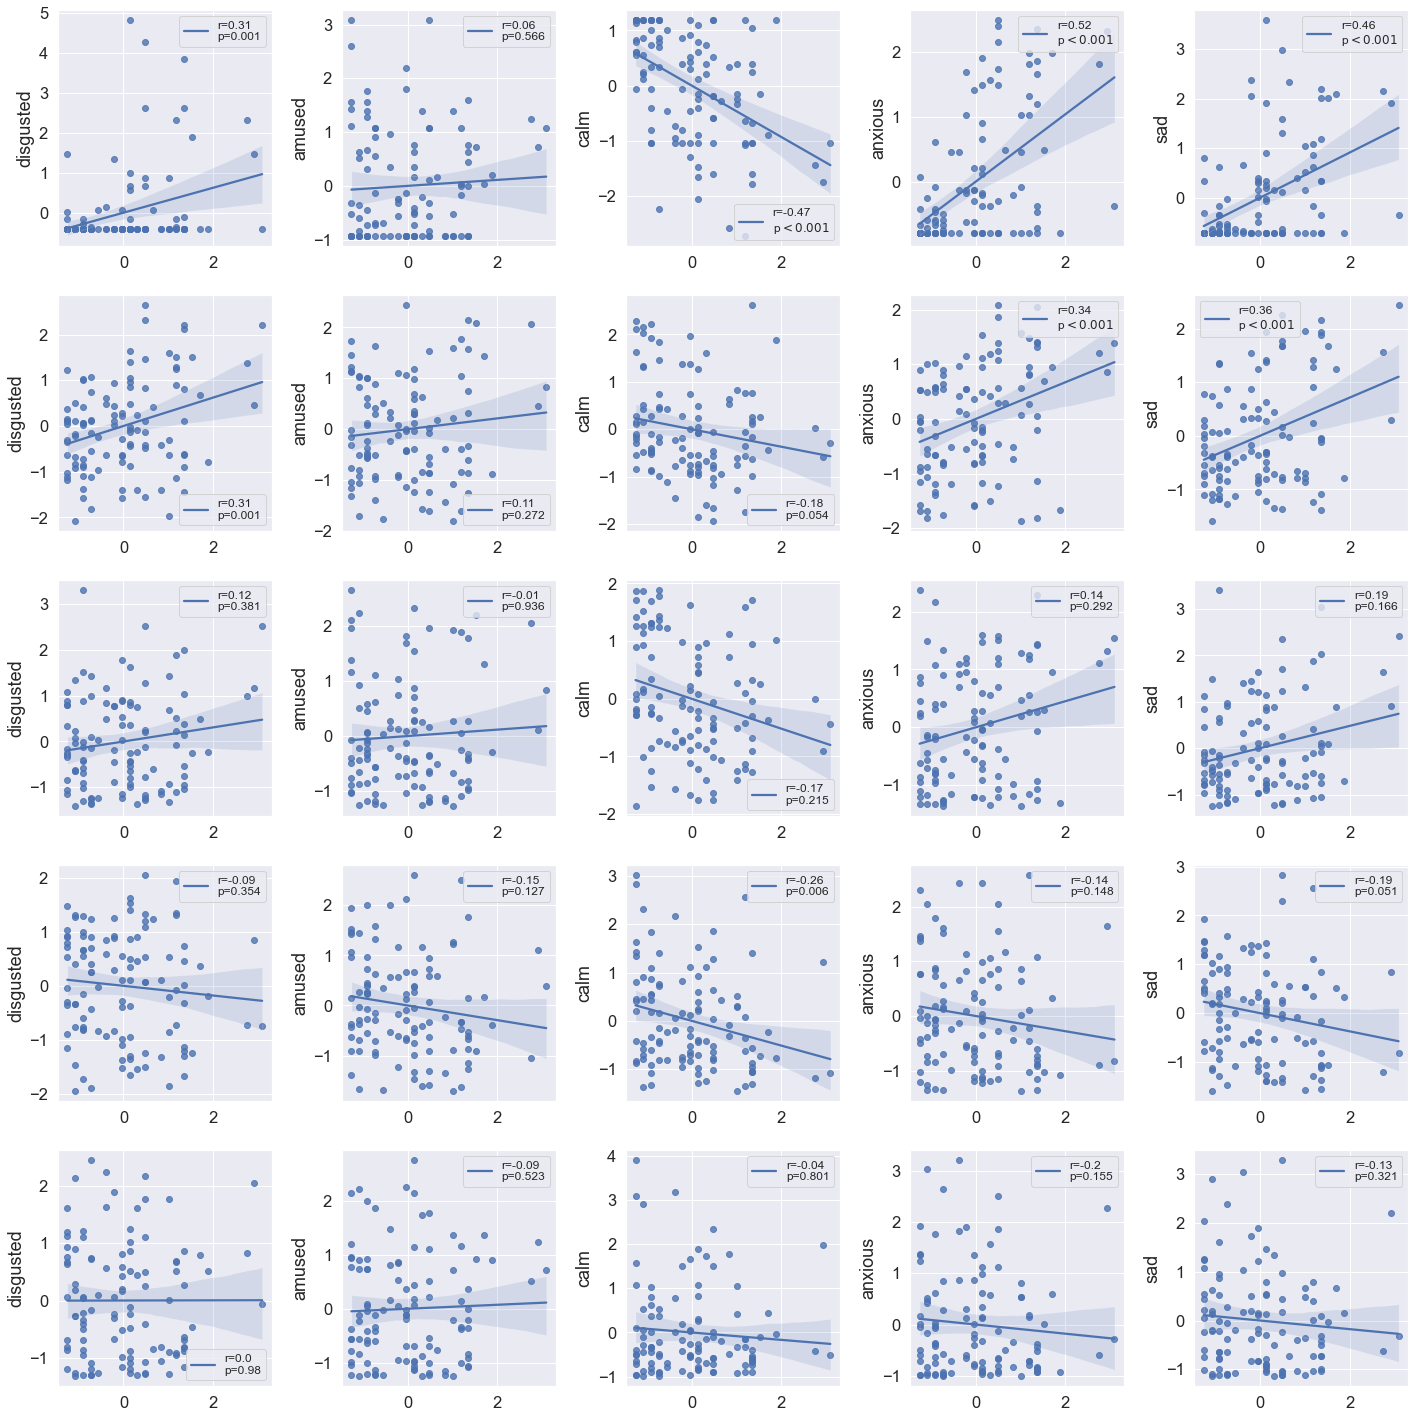

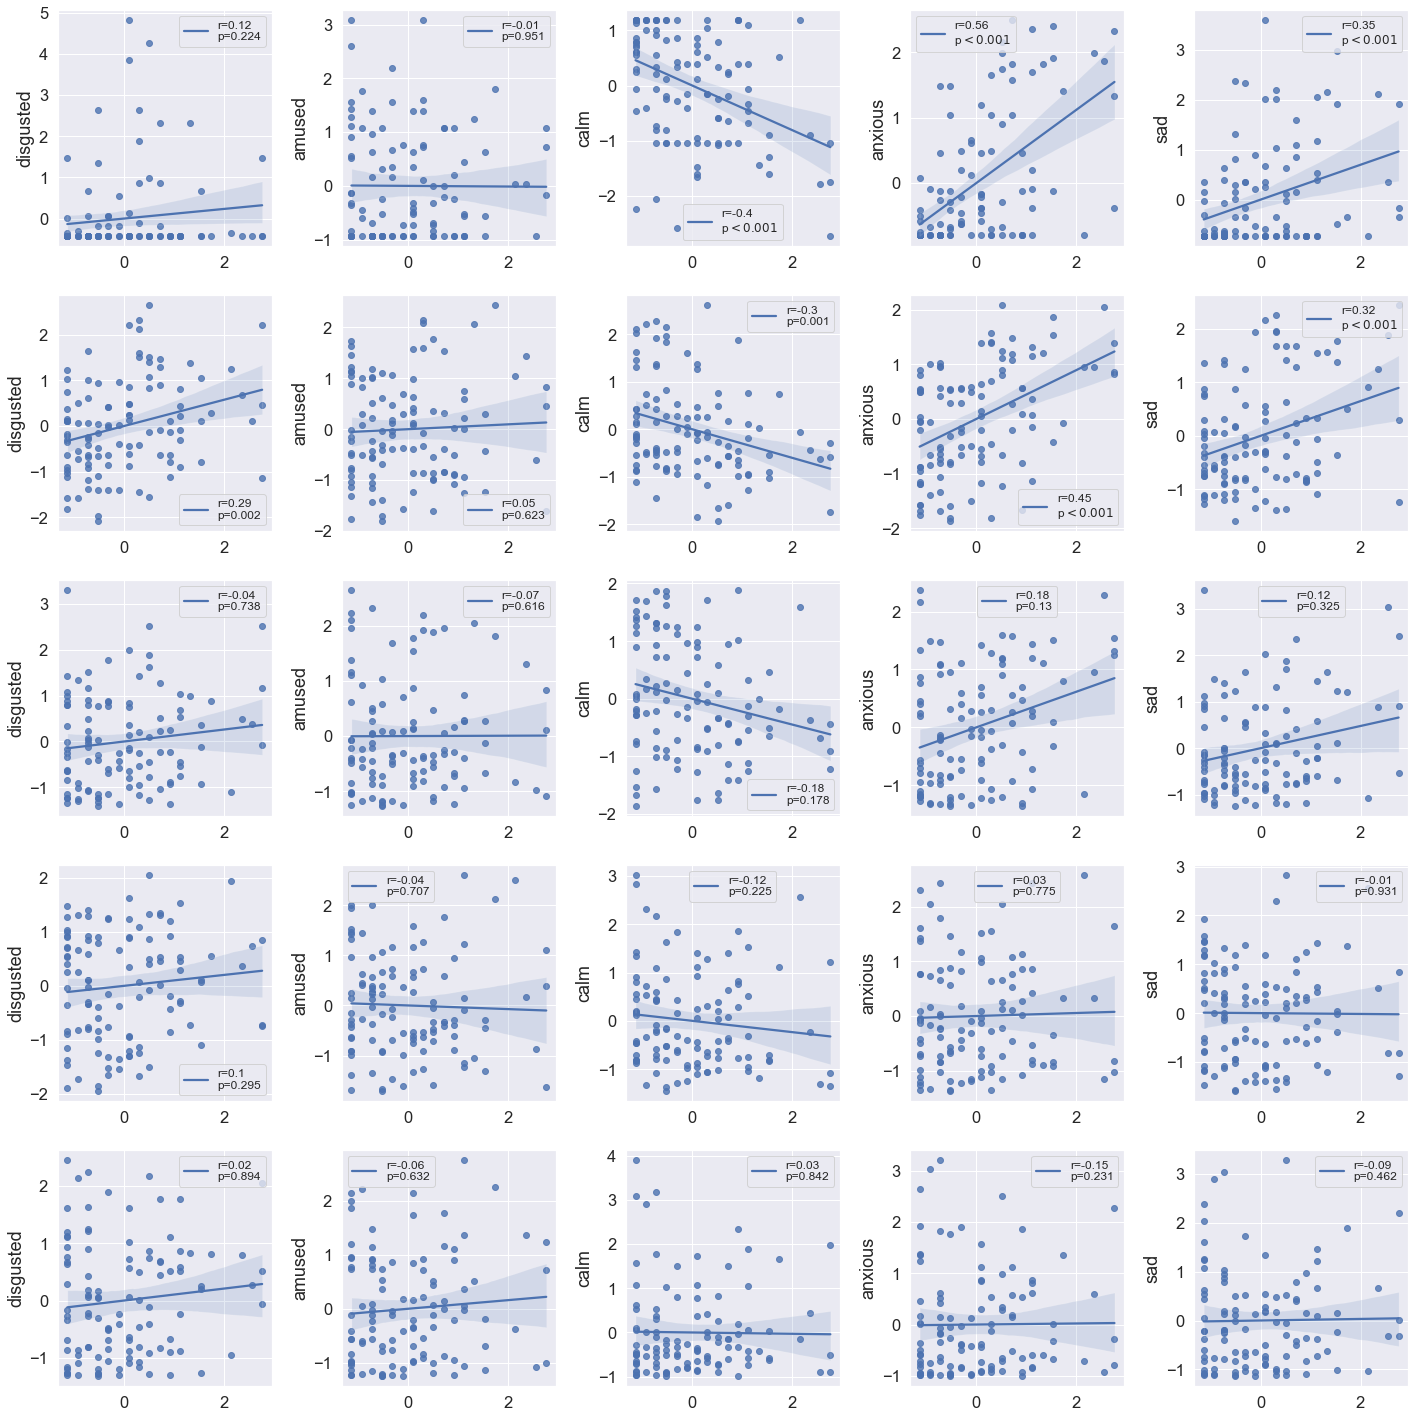

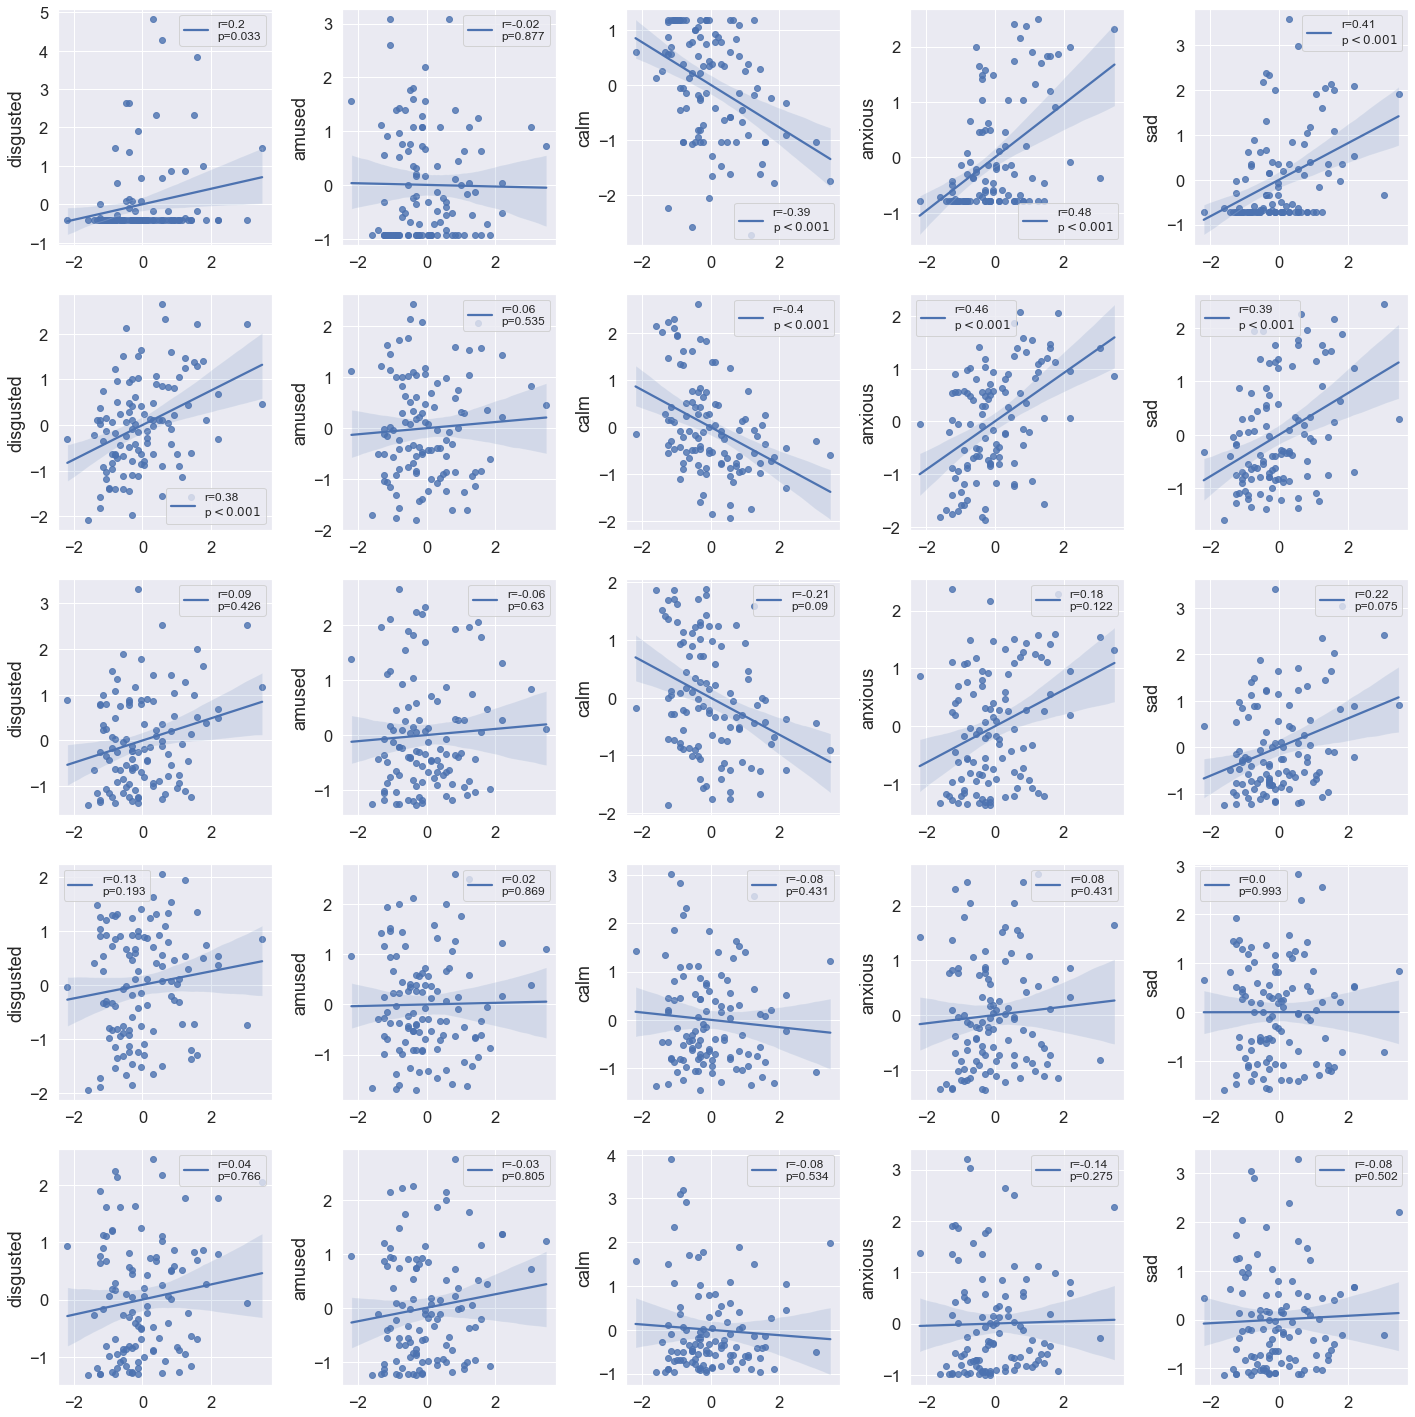

In [53]:
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']
for r, q in enumerate(questionnaires):
    fig,axs= plt.subplots(len(timing), len(mood_categories), figsize=(20,20))
    grid = plt.GridSpec(len(timing), len(mood_categories))
    for m,t in enumerate(timing.keys()):
        c = [i for i in df_mood.columns if t in i]
        for n,cc in enumerate(c):
            slope = df_stats_all[r][(mood_categories[n],'coef')].loc[q + ' -> ' + t]
            p_value = df_stats_all[r][(mood_categories[n],'P>|z|')].loc[q + ' -> ' + t]
            if not (type(p_value) == str): p_value = '=' + str(np.round(p_value,3))
            b = sns.regplot(data = df_mood, x=q, y=cc, ax=axs[m,n], \
                            line_kws={'label': 'r=' + str(np.round(slope,2)) + '\np' + p_value})
            b.legend(prop={'size': 12})
            if m == len(timing): b.set(xlabel=questionnaire_label[r])
            else: b.set(xlabel='')
            b.set(ylabel=mood_categories[n])
#         create_subtitle(fig, grid[m, ::], list(timing.keys())[m])
    fig.tight_layout()
if savefig:
    plt.savefig(filepath + '/results/figures/' + q + '_basics.png')
plt.savefig(filepath + '/results/symptomcorrelations_basics.png')

In [12]:
# multiple comparison
0.05/15

0.0033333333333333335

Test Re-Test
--

In [61]:
# find duplicated videos to see if the ratings are stable
df_finalVideoList = pd.read_csv('../experiment/public/prep/videosForExperiment.csv')

videopath = data[0]['datadoc']['video_path'].split(',')
videoclips =[]
for i, j in enumerate(videopath):
    if i == len(videopath)-1: videoclips.append(j[-11:-7])
    else: videoclips.append(j[-10:-6])
df_videoclips = pd.DataFrame(videoclips)
dublicates = df_videoclips[df_videoclips.duplicated()]

df_videoclips = pd.DataFrame(videoclips, columns=['videoclips'])
df_videoclips.loc[-1] = np.nan
df_videoclips.loc[53.5] = np.nan
df_videoclips = df_videoclips
duplicates = pd.unique(df_videoclips['videoclips'][df_videoclips.duplicated()].dropna())
for i in duplicates:
    df_videoclips == i


In [62]:
# calculate variance in ratings for same video
random_var=[]
for i in range(10000):
    random_var.append(np.var(np.round(np.random.uniform(0, 100, [3,5])),axis=0))
print('var in randomly generated ratings: ' + str(np.mean(random_var)))

nonrandom_var=[]
for i in range(10000):
    x = np.round(np.random.uniform(0, 100, [5,1]))
    x = np.repeat(x, 3, axis=1)
    x[:,1:] = np.round(x[:,1:] + np.random.normal(0, 10, [5,2]))
    nonrandom_var.append(np.var(x,axis=1))
print('var in closely (± N(0,10)) generated ratings: ' + str(np.mean(nonrandom_var)))

ratematching_duplicates = np.full([3,5,4,Nsj], np.nan)
video_cat = []
for sj in range(Nsj):
    for v in range(2):
        duplicates = np.unique(df_finalVideoList['videoset' + str(v+1)]\
                               [df_finalVideoList['videoset' + str(v+1)].duplicated()])
        for j,i in enumerate(duplicates):
            if sj==0: video_cat.append(df_finalVideoList['category'][df_finalVideoList['videoset' + str(v+1)]==i].iloc[0])
            tmp = mood_ratings_split[1:,:,sj,0]
            if df['randomized_videoset'].iloc[sj] == v:
                ratematching_duplicates[:,:,j+v*2,sj] = tmp[df_finalVideoList['videoset' + str(v+1)].str.contains(i),:]

display(pd.DataFrame(np.mean(np.var(ratematching_duplicates,axis=0),axis=(0)), \
             index=['video' + str(i) + video_cat[i] for i in range(4)], \
             columns=['sub' + str(i) for i in range(Nsj)]).round())
print(np.nanmean(np.var(ratematching_duplicates,axis=0),axis=(0,2)))

var in randomly generated ratings: 556.6055955555555
var in closely (± N(0,10)) generated ratings: 44.97079555555556


,sub0,sub1,sub2,sub3,sub4,sub5,sub6,sub7,sub8,sub9,...,sub98,sub99,sub100,sub101,sub102,sub103,sub104,sub105,sub106,sub107
video0Disgust,334.0,NaN,60.0,190.0,NaN,726.0,55.0,NaN,NaN,70.0,...,61.0,159.0,NaN,NaN,NaN,366.0,NaN,NaN,113.0,76.0
video1Amusement,1.0,NaN,25.0,31.0,NaN,21.0,66.0,NaN,NaN,17.0,...,32.0,8.0,NaN,NaN,NaN,177.0,NaN,NaN,9.0,121.0
video2Amusement,NaN,196.0,NaN,NaN,96.0,NaN,NaN,105.0,166.0,NaN,...,NaN,NaN,290.0,14.0,96.0,NaN,26.0,37.0,NaN,NaN
video3Disgust,NaN,358.0,NaN,NaN,213.0,NaN,NaN,943.0,69.0,NaN,...,NaN,NaN,398.0,30.0,133.0,NaN,54.0,284.0,NaN,NaN


[228.51777778  74.04888889  92.99907407 192.37037037]


In [64]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
rpy2.robjects.numpy2ri.activate()
psych = importr("psych")
df_results = pd.DataFrame()
cat = []
for s in range(2):
    for i in range(2):
        duplicate = np.unique(df_finalVideoList['videoset' + str(s+1)]\
                                   [df_finalVideoList['videoset' + str(s+1)].duplicated()])[i]
        B = mood_ratings_split[1:,i*1,(df['randomized_videoset']==s),0][(df_finalVideoList['videoset' + str(s+1)]==duplicate)]
        print(pd.DataFrame(B).T.corr())
        nr,nc = B.shape
        Br = ro.r.matrix(B, nrow=nr, ncol=nc)
        icc = psych.ICC(Br)
        df_results = pd.concat((df_results, pd.DataFrame(icc[0]).loc[4]),axis=1)
        cat.append(df_finalVideoList['category'][df_finalVideoList['videoset' + str(s+1)]==duplicate].values[0] + \
                  ' VS ' + str(s+1))
df_results = df_results.T 
df_results.index = cat
df_results = df_results.rename(columns={"p": "pvalue"})
df_results['pvalue'][df_results['pvalue']<0.001] = '$<$0.001'
display(df_results)
# print(df_results.drop(columns='type').to_latex(escape=False))

          0         1         2
0  1.000000  0.541433  0.514912
1  0.541433  1.000000  0.827547
2  0.514912  0.827547  1.000000
          0         1         2
0  1.000000  0.747500  0.822783
1  0.747500  1.000000  0.810287
2  0.822783  0.810287  1.000000
          0         1         2
0  1.000000  0.723439  0.805511
1  0.723439  1.000000  0.906393
2  0.805511  0.906393  1.000000
          0         1         2
0  1.000000  0.594215  0.520378
1  0.594215  1.000000  0.755179
2  0.520378  0.755179  1.000000


,type,ICC,F,df1,df2,pvalue,lower bound,upper bound
Disgust VS 1,ICC2k,0.805443,12.198295,2.0,118.0,$<$0.001,0.448435,0.994404
Amusement VS 1,ICC2k,0.34269,3.508359,2.0,118.0,0.033107,-0.015969,0.966203
Amusement VS 2,ICC2k,0.33815,3.603984,2.0,94.0,0.03104,-0.011537,0.965189
Disgust VS 2,ICC2k,0.548665,4.074898,2.0,94.0,0.020084,0.026813,0.984429
